In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import autograd.numpy as anp

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
##############


In [2]:
from qfuncs import *

In [3]:
dev = qml.device('default.qubit', wires=8, shots=1000)

In [4]:
data = joblib.load('./params.job')

X_data = np.array(data[0][1])
Y_data = np.array(data[0][2])

for J in range(1,len(data)):
    X_data = np.concatenate((X_data, np.array(data[J][1])))
    Y_data = np.concatenate((Y_data, np.array(data[J][2])))
    
print('Size of Training Set: {0}'.format(np.shape(X_data)[0]))

Size of Training Set: 50


In [5]:
def convolution_8(params,N=8):
    k = 0
    
    for wire, wire_next in zip(range(0,N,2), range(1,N,2)):
        qml.RY(params[k], wires = wire)
        k = k + 1
        qml.RZ(params[k], wires = wire)
        k = k + 1
        
        qml.CNOT(wires=[wire, wire_next])
        
    qml.Barrier()
    
    for wire, wire_next in zip(range(N-2,0,-2), range(N-3,-1,-2)):
        qml.RY(params[k], wires = wire_next)
        k = k + 1
        
        qml.CNOT(wires=[wire_next, wire])

        
def pooling_8(params, N=8):
    qml.Barrier()
    
    k = N
    # First pooling 8->4
    for wire_meas, wire_next in zip(range(0,N,2), range(1,N,2)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RY)(params[k], wires=wire_next)
        k = k + 1
    
    qml.Barrier()
    
    # Second pooling 4->2
    for wire_meas, wire_next in zip(range(1,N,4), range(3,N,4)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        
    qml.Barrier()
    
    qml.RZ(params[k], wires = 3)
    k = k + 1
    qml.RY(params[k], wires = 3)
    k = k + 1
    qml.RZ(params[k], wires = 7)
    k = k + 1
    qml.RY(params[k], wires = 7)
    k = k + 1
    
    # Third pooling 2->1
    for wire_meas, wire_next in zip(range(3,N,8), range(7,N,4)):
        m_0 = qml.measure(wire_meas)

        qml.cond(m_0 ==0, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        qml.cond(m_0 ==1, qml.RY)(params[k], wires=wire_next)
        k = k + 1
        
@qml.qnode(dev)        
def qcnn_8(params_vqe,params):
    vqe_ising_chain_circuit(params_vqe, 8)
    qml.Barrier()
    convolution_8(params)
    pooling_8(params)
    
    return qml.probs(wires=7)

In [6]:
def cross_entropy_loss(labels, predictions):
    '''
    f = - Σ [(Yi*log(Pi) + (1 - Yi)*log(1 - Pi) )]  for i in TrainingSet
    '''
    loss = 0
    for l, p in zip(labels, predictions):
        term = ( l * np.log(p) + (1 - l) * np.log(1 - p) )
        loss = loss + term

    return -1 * loss

def cross_entropy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (anp.log(p[l])) + (1 - l) * anp.log(1 - p[1 - l])
        loss = loss + c_entropy

    return -1 * loss

In [7]:
def cost_fn(params, X, Y):
    predictions = [qcnn_8(x, params) for x in X]
    loss = cross_entropy(Y, predictions)
    
    return loss

In [8]:
def compute_accuracy(X_train, Y_train, params):
    '''
    Accuracy = (corretly predicted labels)/(total # of labels) * 100 ( %100) 
    '''
    data_len = len(X_train)
    
    correct = 0
    for i, data in enumerate(X_train):
        if np.argmax( qcnn_8(data, params) ) == Y_train[i]:
            correct = correct + 1
            
    return correct / data_len * 100

In [9]:
def qcnn_training(X_train, Y_train, X_test = [], Y_test = [], steps = 100, lr = 0.001, batch_size = 25, N = 8, plot = True):
    # Initialize parameters randomly
    params = np.random.randn(4*N-2)
    
    # Set optimizer
    opt = qml.GradientDescentOptimizer(stepsize=lr)
    
    loss_history = []
    accuracy_history = []
    loss_history_test = []
    accuracy_history_test = []
    
    batch_size = min(len(X_train), batch_size)
    
    progress = tqdm(range(steps))
    for epoch in progress:
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        batch_index = np.arange(len(X_train))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]

        # Compute current loss and update parameters
        params, cost_new = opt.step_and_cost(lambda v: cost_fn(v, X_batch, Y_batch), params)
        
        loss_history.append(cost_new)
        accuracy_history.append(compute_accuracy(X_train, Y_train, params))
        if len(X_test) > 0:
            loss_history_test.append(cost_fn(params, X_test, Y_test))
            accuracy_history_test.append(compute_accuracy(X_test, Y_test, params))
        
        # Set description to current loss
        progress.set_description('Cost: {0}'.format(np.round(cost_new,3)))

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(steps), np.asarray(loss_history)/len(X_train), label = 'Training Loss')
        if len(X_test) > 0:
            plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
            plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(steps), accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(steps), accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

In [10]:
drawer = qml.draw(qcnn_8)
print(drawer([0]*100,[0]*100))

0: ──RY(0.00)─╭C────────────────────||──RY(0.00)──||──RY(0.00)──RZ(0.00)─╭C──||───────────────||
1: ──RY(0.00)─╰X─╭C─────────────────||──RY(0.00)──||─────────────────────╰X──||──RY(0.00)─╭C──||
2: ──RY(0.00)────╰X─╭C──────────────||──RY(0.00)──||──RY(0.00)──RZ(0.00)─╭C──||───────────╰X──||
3: ──RY(0.00)───────╰X─╭C───────────||──RY(0.00)──||─────────────────────╰X──||──RY(0.00)─╭C──||
4: ──RY(0.00)──────────╰X─╭C────────||──RY(0.00)──||──RY(0.00)──RZ(0.00)─╭C──||───────────╰X──||
5: ──RY(0.00)─────────────╰X─╭C─────||──RY(0.00)──||─────────────────────╰X──||──RY(0.00)─╭C──||
6: ──RY(0.00)────────────────╰X─╭C──||──RY(0.00)──||──RY(0.00)──RZ(0.00)─╭C──||───────────╰X──||
7: ──RY(0.00)───────────────────╰X──||──RY(0.00)──||─────────────────────╰X──||───────────────||

──╭C─────────────────────────╭C──────────────────────────||───────────────────────────
──╰ControlledOperation(0.00)─╰ControlledOperation(0.00)──||─╭C────────────────────────
──╭C─────────────────────────╭C──────────────────

In [11]:
train_index = np.random.choice(np.arange(len(X_data)), size=int(0.8*len(X_data)), replace=False )

test_index = []
for i in np.arange(len(X_data)):
    if not i in train_index:
        test_index.append(i)       
test_index = np.array(test_index)

In [12]:
X_train = X_data[train_index]
Y_train = Y_data[train_index]

X_test = X_data[test_index]
Y_test = Y_data[test_index]

  0%|          | 0/250 [00:00<?, ?it/s]

Final Loss: 11.341055104632753
Final Accuracy: 97.5%


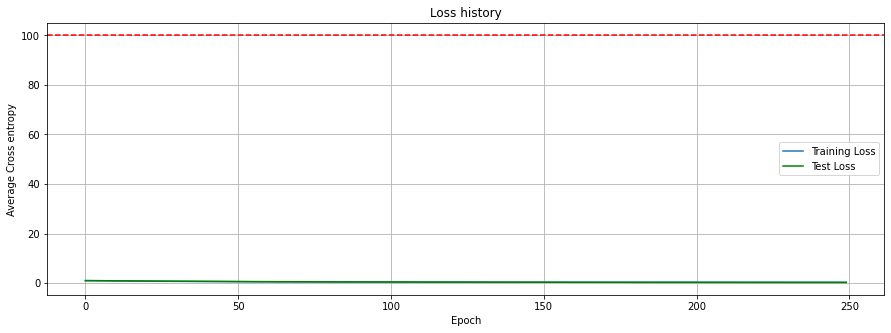

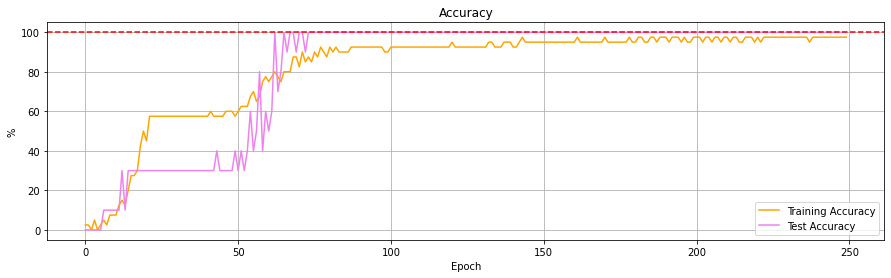

In [13]:
loss_history, accuracy_history, params = qcnn_training(X_train, Y_train, X_test, Y_test, lr = 1e-3, steps = 250)

print('Final Loss: {0}\nFinal Accuracy: {1}%'.format(loss_history[-1], accuracy_history[-1]) )

In [14]:
np.array([1,2])/10

tensor([0.1, 0.2], requires_grad=True)

In [15]:
joblib.dump(params, './params_qcnn.job')

['./params_qcnn.job']

In [16]:
drawer = qml.draw(qcnn_8)
print(drawer(X_train[2],params))

0: ──RY(1.66)──╭C────────────────────||──RY(-0.59)──||──RY(0.76)───RZ(0.06)──╭C──||──────────────
1: ──RY(-1.40)─╰X─╭C─────────────────||──RY(-0.42)──||───────────────────────╰X──||──RY(-0.18)─╭C
2: ──RY(1.50)─────╰X─╭C──────────────||──RY(-0.37)──||──RY(-0.39)──RZ(-0.00)─╭C──||────────────╰X
3: ──RY(-1.52)───────╰X─╭C───────────||──RY(-0.37)──||───────────────────────╰X──||──RY(0.54)──╭C
4: ──RY(1.51)───────────╰X─╭C────────||──RY(-0.37)──||──RY(1.26)───RZ(-0.39)─╭C──||────────────╰X
5: ──RY(-1.51)─────────────╰X─╭C─────||──RY(-0.37)──||───────────────────────╰X──||──RY(1.24)──╭C
6: ──RY(1.50)─────────────────╰X─╭C──||──RY(-0.44)──||──RY(0.70)───RZ(-1.57)─╭C──||────────────╰X
7: ──RY(-1.40)───────────────────╰X──||──RY(-0.68)──||───────────────────────╰X──||──────────────

───||─╭C─────────╭C──────────||───────────────────────||────────────────────────────────────────────┤
───||─╰RY(1.24)──╰RY(0.54)───||─╭C─────────╭C─────────||────────────────────────────────────────────┤
───||─╭C───